In [700]:
import math
import copy

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from functools import cmp_to_key

In [701]:
class Cell(object):
    """
    A representation of a game cell.
    """
    
    def __init__(self, position, cell_type, constraint):
        """
        Creates a game cell.
        
        :parameter position: the position of the cell.
        :type position: 2-dimensional tuple.
        :parameter cell_type: {'free', 'free_lighted', 'light', 'wall', 'constrained_wall'}.
        :type cell_type: string.
        :parameter constraint: number of lights that must be adjacent to the current cell.
        :type constraint: int.
        """
        self.position = position
        self.cell_type = cell_type
        self.constraint = constraint
        
    def set_cell_type(self, cell_type):
        """
        Changes the cell type.
        
        :parameter cell_type: {'free', 'free_lighted', 'light'}.
        :type cell_type: string.
        """
        self.cell_type = cell_type
        

In [835]:
class Board(object):
    """
    A representation of the game board.
    """
    
    def __init__(self, width, height, wall_positions):
        """
        Creates the game board.
        
        :parameter width: number of columns of the board.
        :type width: int.
        :parameter height: number of rows of the board.
        :type height: int.
        :parameter wall_positions: a list of wall positions.
        :type wall_positions: list of 3-dimensional tuple: (row, column, constraint).
        """
        self.board_width = width
        self.board_height = height
        self.board = []
        for i in range(self.board_height):
            self.board.append([])
            for j in range(self.board_width):
                self.board[i].append([])

        for i in range(width):
            for j in range(height):
                current_pos = (i, j)
                cell_type = 'free'
                constraint = None
                
                # Verify if current cell is a wall
                for wall_pos in wall_positions:
                    if i == wall_pos[0] and j == wall_pos[1]:
                        if wall_pos[2] is None:
                            cell_type = 'wall'
                        else:
                            cell_type = 'constrained_wall'
                            constraint = wall_pos[2]

                self.board[i][j] = Cell(current_pos, cell_type, constraint)
        
    def is_pos_valid(self, position):
        """
        Verifies if a given position respects the board dimensions.
        
        :parameter position: position that we want to check.
        :type position: 2-dimensional tuple.
        :rtype: bool.
        """
        if position[0] < 0 or position[0] >= self.board_width:
            return False
        elif position[1] < 0 or position[1] >= self.board_height:
            return False
        return True
    
    def illuminate_cells(self, light_position):
        """
        Illuminate cells based on the light position.
        
        :parameter light_position: the position of the light.
        :type initial_position: 2-dimensional tuple.
        """
        current_row = light_position[0] - 1
        while current_row >= 0:
            cell_type = self.board[current_row][light_position[1]].cell_type
            if cell_type == 'free':
                self.board[current_row][light_position[1]].set_cell_type('free_lighted')
            elif cell_type == 'wall' or cell_type == 'constrained_wall':
                break
            current_row -= 1

        current_row = light_position[0] + 1
        while current_row < self.board_width:
            cell_type = self.board[current_row][light_position[1]].cell_type
            if cell_type == 'free':
                self.board[current_row][light_position[1]].set_cell_type('free_lighted')
            elif cell_type == 'wall' or cell_type == 'constrained_wall':
                break
            current_row += 1

        current_col = light_position[1] - 1
        while current_col >= 0:
            cell_type = self.board[light_position[0]][current_col].cell_type
            if cell_type == 'free':
                self.board[light_position[0]][current_col].set_cell_type('free_lighted')
            elif cell_type == 'wall' or cell_type == 'constrained_wall':
                break
            current_col -= 1

        current_col = light_position[1] + 1
        while current_col < self.board_height:
            cell_type = self.board[light_position[0]][current_col].cell_type
            if cell_type == 'free':
                self.board[light_position[0]][current_col].set_cell_type('free_lighted')
            elif cell_type == 'wall' or cell_type == 'constrained_wall':
                break
            current_col += 1
        
    def place_light(self, position):
        """
        Places a light at position if possible.
        
        :parameter position: the light's position.
        :type position: 2-dimensional tuple.
        :return: if the light was successfully placed at position.
        :rtype: bool.
        """
        if self.is_pos_valid(position):
            if self.board[position[0]][position[1]].cell_type == 'free' or self.board[position[0]][position[1]].cell_type == 'free_lighted': 
                self.board[position[0]][position[1]] = Cell(position, 'light', None)
                self.illuminate_cells(position)
                                
                return True
            else:
                return False
        else:
            raise IndexError()
                        
    def print_ascii_board(self):
        """
        Prints board using ASCII characters.
        F character is used for free cells.
        W character is used for unconstrained walls.
        L character is used for lights.
        FL string is used for free lighted cells.
        Numbers are used for constrained walls. They indicate the number of adjacent lights required.
        """
        for i in range(self.board_width):
            for j in range(self.board_height):
                cell_type = self.board[i][j].cell_type
                if cell_type == 'free':
                    print('F  ', end='')
                elif cell_type == 'constrained_wall':
                    print(f'{self.board[i][j].constraint}  ', end='')
                elif cell_type == 'wall':
                    print('W  ', end='')
                elif cell_type == 'light':
                    print('L  ', end='')
                elif cell_type == 'free_lighted':
                    print('FL ', end='')
            print('\n')

    def print_board(self, save=False):
        """
        Prints board with colors.
        """
        colors = np.array([[1, 1, 1, 1],
                           [0, 0, 0, 1]])
        cmap = ListedColormap(colors)
        cell_type_numbers = {'free': 0,
                             'free_lighted': 0,
                             'light': 0,
                             'wall': 1,
                             'constrained_wall': 1}

        grid = np.zeros((self.board_height, self.board_width))
        for i in range(self.board_height):
            for j in range(self.board_width):
                cell_type = self.board[i][j].cell_type
                grid[i][j] = cell_type_numbers[cell_type]
                
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.matshow(grid, cmap=cmap)
        ax.set_xlim([-0.5, self.board_width - 0.5])
        ax.xaxis.set_ticks(np.arange(-0.5, self.board_width - 0.5, 1))
        ax.xaxis.set_ticklabels([' '] * (self.board_width))
        ax.set_xlabel('j')
        ax.set_ylim([self.board_height - 0.5, -0.5])
        ax.yaxis.set_ticks(np.arange(-0.5, self.board_height - 0.5, 1))
        ax.yaxis.set_ticklabels([' '] * (self.board_height))
        ax.set_ylabel('i')
        ax.tick_params(top=False, left=False, bottom=False)
        ax.grid()

        for i in range(self.board_height):
            for j in range(self.board_width):
                cell_type = self.board[i][j].cell_type
                if cell_type == 'constrained_wall':
                    ax.text(j - 0.15, i + 0.15, self.board[i][j].constraint, color="white", fontsize=24)
                elif cell_type == 'light':
                    ax.plot(j, i, marker='s', markersize=38, color='yellow')
                    ax.plot(j, i, marker='o', markersize=20, color='orange')
                elif cell_type == 'free_lighted':
                    ax.plot(j, i, marker='s', markersize=38, color='yellow')

        if save:
            plt.savefig("board.png", dpi=300, bbox_inches='tight')


In [836]:
class Constraint(object):
    """
    A linear constraint for the Light Up game.
    """
    
    def __init__(self, value, variables):
        """
        Creates a new constraint.
        
        :parameter value: the constraint value.
        :type value: int.
        :parameter variables: variables in the linear constraint.
        :type variables: list of 2-dimensional tuples.
        """
        self.value = value
        self.variables = variables
        
    def print_constraint(self):
        """
        Prints constraint for debugging purposes
        """
        if len(self.variables) == 0:
            print("Empty constraint")
        else:        
            for i in range(len(self.variables) - 1):
                print(self.variables[i], "+ ", end="")
            print(self.variables[len(self.variables) - 1], "=", self.value)
        

In [837]:
class BoardSolverCSP(object):
    """
    A solver of light up problem when modelling it as a Constraint Satisfaction Problem (CSP).
    """
    
    def __init__(self, board):
        """
        Creates a solver for the Light Up game.
        
        :parameter board: the game board.
        :type board: Board.
        """
        self.board = board
        self.wall_constraints = self._get_wall_contraints(self.board)

    def _get_wall_contraints(self, board):
        """
        Returns the constraints of the walls with numbers.
        
        :parameter board: the game board.
        :type board: Board.
        :return: the wall constraints.
        :rtype: list of Constraint objects.
        """
        constraints = []
        for i in range(board.board_width):
            for j in range(board.board_height):
                cell_type = board.board[j][i].cell_type
                if cell_type == 'constrained_wall':
                    adjacent_pos = [(j + 1, i), (j - 1, i), (j, i + 1), (j, i - 1)]
                    
                    # Verify if adjacent positions are valid and free
                    adjacent_pos = [pos for pos in adjacent_pos if board.is_pos_valid(pos)]
                    adjacent_pos = [pos for pos in adjacent_pos if board.board[pos[0]][pos[1]].cell_type == 'free']
                    
                    constraint = Constraint(board.board[j][i].constraint, adjacent_pos)
                    constraints.append(constraint)
        
        # Sort constraints by max. value
        constraints.sort(key=lambda x: -x.value)

        return constraints
    
    def _clean_empty_constraints(self, constraints):
        """
        Removes all empty constraints.

        :parameter constraints: The current wall constraints.
        :type constraints: List of Constraint objects.
        :return: New constraints list without empty constraints.
        :type return: List of Constraint objects.
        """
        should_remove = [False]*len(constraints)
        for i in range(len(constraints)):
            if len(constraints[i].variables) == 0:
                should_remove[i] = True

        for i in range(len(should_remove)):
            if should_remove[i]:
                constraints.pop(i)

    def _set_variable(self, constraints, variable, value):
        """
        Set a value to a variable and propagate it along the constraints.

        :parameter constraints: the current wall constraints.
        :type constraints: list of Constraint objects.
        :parameter variable: the variable that was set to 1.
        :type variable: 2-dimensional tuple.
        :parameter value: the value of variable.
        :type value: int.
        :return: the list of updated constraints.
        """
        new_constraints = []
        found_variable = False
        for constraint in constraints:
            new_constraints.append(Constraint(None, []))
            for constraint_variable in constraint.variables:
                new_constraints[-1].variables.append(constraint_variable)
                if variable == constraint_variable:
                    found_variable = True

            new_constraints[-1].value = constraint.value

            if found_variable:
                new_constraints[-1].variables.remove(variable)
                new_constraints[-1].value -= value
                found_variable = False

        return new_constraints

    def _verify_constraints_value(self, constraints):
        """
        Verify if a set of constraints have their values greater than 0.

        :parameter constraints: the current wall constraints.
        :type constraints: list of Constraint objects.
        :return: if the constraints are valid or not.
        :type return: bool.
        """
        for constraint in constraints:
            if constraint.value < 0:
                return False
            if len(constraint.variables) == 0 and constraint.value != 0:
                return False
            if len(constraint.variables) - constraint.value < 0:
                return False
        return True
    
    def _get_free_positions(self, board):
        free_positions = []
        for i in range(board.board_height):
            for j in range(board.board_width):
                cell_type = board.board[i][j].cell_type
                if cell_type == 'free':
                    free_positions.append((i, j))

        return free_positions

    def _get_amount_lighted_cells(self, board, pos):
        amount = 1

        row = pos[0] - 1
        col = pos[1]
        while row >= 0:
            cell_type = board.board[row][col].cell_type
            if cell_type == 'free':
                amount += 1
            elif cell_type == 'wall' or cell_type == 'constrained_wall':
                break
            elif cell_type == 'light':
                # Invalid position
                amount = -1
                return amount
            row -= 1

        row = pos[0] + 1
        while row < board.board_height:
            cell_type = board.board[row][col].cell_type
            if cell_type == 'free':
                amount += 1
            elif cell_type == 'wall' or cell_type == 'constrained_wall':
                break
            elif cell_type == 'light':
                # Invalid position
                amount = -1
                return amount
            row += 1

        row = pos[0]
        col = pos[1] + 1
        while col < board.board_width:
            cell_type = board.board[row][col].cell_type
            if cell_type == 'free':
                amount += 1
            elif cell_type == 'wall' or cell_type == 'constrained_wall':
                break
            elif cell_type == 'light':
                # Invalid position
                amount = -1
                return amount
            col += 1

        col = pos[1] - 1
        while col >= 0:
            cell_type = board.board[row][col].cell_type
            if cell_type == 'free':
                amount += 1
            elif cell_type == 'wall' or cell_type == 'constrained_wall':
                break
            elif cell_type == 'light':
                # Invalid position
                amount = -1
                return amount
            col -= 1

        return amount

    def _get_greedy_positions(self, board, cannot_place):
        free_positions = self._get_free_positions(board)

        if len(free_positions) == 0:
            return None

        free_positions = [i for i in free_positions if i not in cannot_place]
        greedy_positions = []
        for position in free_positions:
            cost = self._get_amount_lighted_cells(board, position)
            if cost != -1:
                greedy_positions.append((position, cost))
        
        # Must sort greedy positions by cost
        greedy_positions.sort(key=lambda x: -x[1])
        return greedy_positions

    def _solve_greedy(self, board, can_place, cannot_place, verbose=False):
        initial_board = copy.deepcopy(board)
        initial_can_place = list(can_place)
        positions = self._get_greedy_positions(board, cannot_place)

        if verbose:
            board.print_ascii_board()
            print(positions)

        if positions is None:
            return True, board, can_place
        elif len(positions) == 0:
            return False, board, can_place
        else:
            for pos in positions:
                board.place_light(pos[0])
                can_place.append(pos[0])
                solve_status, board, can_place = self._solve_greedy(board, can_place, cannot_place)

                if solve_status is True:
                    return True, board, can_place
                else:
                    board = initial_board
                    can_place = initial_can_place

            # Did not find any solution
            return False, initial_board, initial_can_place

    def solve(self, board, constraints, can_place, cannot_place, verbose=False):
        """
        Returns the game's solution.
        
        :parameter constraints: Stores the constraints at the current function call.
        :type constraints: List of Constraint objects.
        :parameter can_place: Stores the list of variables (i.e., lights' position) with value 1 in the current function call.
                              Must be an empty list in the first call of the function.
        :type can_place: List of 2-dimensional tuples.
        :parameter cannot_place: Stores the list of variables with value 0 in the current function call.
                                 Must be an empty list in the first call of the function.
        :type cannot_place: List of 2-dimensional tuple.
        :return: If the search for a solution was successful.
        :type return: Bool.
        """
        self._clean_empty_constraints(constraints)

        can_place_save = list(can_place)
        cannot_place_save = list(cannot_place)
        board_save = copy.deepcopy(board)

        if len(constraints) == 0:
            if verbose:
                print("First step finished.")
                board.print_ascii_board()

            solve_status, board, can_place = self._solve_greedy(board, can_place, cannot_place)
            if solve_status is False:
                board = board_save
                can_place = can_place_save

            if verbose:
                print(f"Solve status: {solve_status}")
                board.print_ascii_board()
                
            return solve_status, can_place, cannot_place, board
            
        variable_to_set = constraints[0].variables[0]
        found_solution = False

        constraints_set_zero = self._set_variable(constraints, variable_to_set, 0)

        if verbose:
            print(variable_to_set)
            board.print_ascii_board()

        equations_solvable = self._verify_constraints_value(constraints_set_zero)
        if equations_solvable:
            cannot_place.append(variable_to_set)
            found_solution, can_place, cannot_place, board = self.solve(board, constraints_set_zero, can_place, cannot_place)
        else:
            found_solution = False

        if not found_solution:
            can_place = can_place_save
            cannot_place = cannot_place_save
        else:
            return True, can_place, cannot_place, board

        if verbose:
            print(variable_to_set)
            for constraint in constraints:
                constraint.print_constraint()

        if board.board[variable_to_set[0]][variable_to_set[1]].cell_type == 'free':
            constraints_set_one = self._set_variable(constraints, variable_to_set, 1)
            equations_solvable = self._verify_constraints_value(constraints_set_one)
            if equations_solvable:
                can_place.append(variable_to_set)
                board.place_light(variable_to_set)

                if verbose:
                    board.print_ascii_board()
                
                found_solution, can_place, cannot_place, board = self.solve(board, constraints_set_one, can_place, cannot_place)
        else:
            found_solution = False

        if not found_solution:
            can_place = can_place_save
            cannot_place = cannot_place_save
            board = board_save
            return False, can_place, cannot_place, board
        else:
            return True, can_place, cannot_place, board

    def print_wall_constraints(self):
        """
        Prints wall constraints for debugging purposes.
        """
        for constraint in self.wall_constraints:
            constraint.print_constraint()


## Board constants

In [838]:
WIDTH = 7
HEIGHT = 7

## Boards definition

In [839]:
# Define wall positions of five boards
# Values defined as (i, j, constraint)
# Constraint "None" means a wall with no number
wall_positions_1 = [(0, 2, 1),
                    (1, 3, 0),
                    (1, 4, None),
                    (2, 1, 0),
                    (2, 6, 2),
                    (3, 1, 0),
                    (3, 3, None),
                    (3, 5, None),
                    (4, 0, None),
                    (4, 5, 1),
                    (5, 2, 3),
                    (5, 3, 1),
                    (6, 4, None)]

wall_positions_2 = [(0, 2, 1),
                    (2, 3, 1),
                    (2, 6, 3),
                    (3, 2, None),
                    (3, 4, 1),
                    (4, 0, 1),
                    (4, 3, 2),
                    (6, 4, 1)]

wall_positions_3 = [(0, 2, 0),
                    (0, 3, 1),
                    (1, 1, 1),
                    (1, 5, None),
                    (2, 6, 1),
                    (3, 0, None),
                    (3, 6, None),
                    (4, 0, 1),
                    (5, 1, 1),
                    (5, 5, 4),
                    (6, 3, None),
                    (6, 4, None)]

wall_positions_4 = [(0, 0, None),
                    (0, 2, 1),
                    (0, 6, 0),
                    (1, 3, None),
                    (2, 6, 2),
                    (3, 1, None),
                    (3, 5, 3),
                    (4, 0, 1),
                    (5, 3, None),
                    (6, 0, 1),
                    (6, 4, None),
                    (6, 6, None)]

wall_positions_5 = [(0, 5, 1),
                    (1, 0, None),
                    (1, 4, 1),
                    (2, 1, None),
                    (4, 5, 3),
                    (5, 2, 3),
                    (5, 6, 2),
                    (6, 1, 3)]

## Solve

In [854]:
# Select the board
# Board possibles: wall_positions_i, i in {1, 2, 3, 4, 5}
wall_positions = wall_positions_4

In [855]:
# Create board and solver
board = Board(WIDTH, HEIGHT, wall_positions)
solver = BoardSolverCSP(board)

In [856]:
# Visualize the board in ASCII characters
board.print_ascii_board()

W  F  1  F  F  F  0  

F  F  F  W  F  F  F  

F  F  F  F  F  F  2  

F  W  F  F  F  3  F  

1  F  F  F  F  F  F  

F  F  F  W  F  F  F  

1  F  F  F  W  F  W  



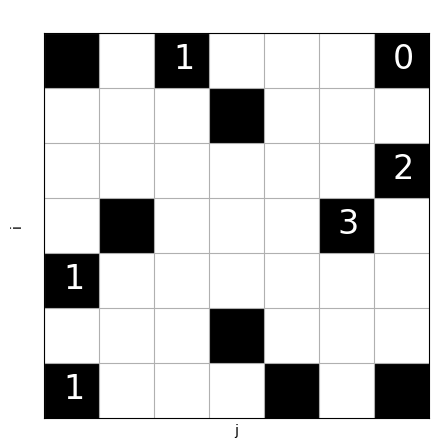

In [857]:
board.print_board()

In [858]:
# Visualize the initial constraints for debug purposes
for constraint in solver.wall_constraints:
    constraint.print_constraint()

(4, 5) + (2, 5) + (3, 6) + (3, 4) = 3
(3, 6) + (1, 6) + (2, 5) = 2
(5, 0) + (3, 0) + (4, 1) = 1
(5, 0) + (6, 1) = 1
(1, 2) + (0, 3) + (0, 1) = 1
(1, 6) + (0, 5) = 0


In [859]:
# Solve the problem and print final board
problem_constraints = solver.wall_constraints
can_place = []
cannot_place =  []
solver_status, can_place, cannot_place, board = solver.solve(board, problem_constraints, can_place, cannot_place)
print(f"Solver status: {solver_status}\n\n")
board.print_ascii_board()

Solver status: True


W  FL 1  L  FL FL 0  

FL L  FL W  L  FL FL 

FL FL FL FL FL L  2  

L  W  FL L  FL 3  L  

1  FL FL FL FL L  FL 

FL FL L  W  FL FL FL 

1  L  FL FL W  FL W  



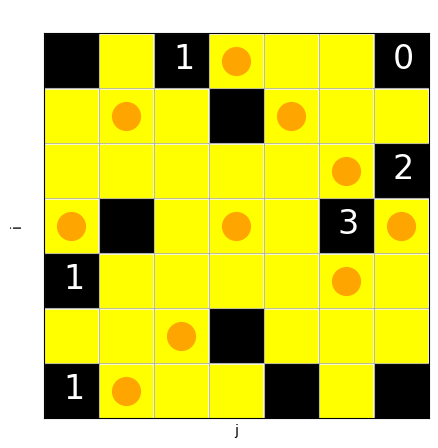

In [861]:
board.print_board()